# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**


In [1]:
!pip install optuna
!pip install lime
!pip install shap
!pip install psycopg2-binary

  Using cached optuna-4.2.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.14.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached Mako-1.3.8-py3-none-any.whl.metadata (2.9 kB)
Using cached optuna-4.2.0-py3-none-any.whl (383 kB)
Using cached alembic-1.14.1-py3-none-any.whl (233 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached Mako-1.3.8-py3-none-any.whl (78 kB)
  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=577445d3d821e12a54ae44f365d6e1db04a36ad825ca2a46f7107ed8b9103a00
  Stored in directory: /Users/zapashniysergey/Library/Caches/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.1 MB/s eta 0:00:0000:0100:010m


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

from hw4_code_pro import DecisionTree

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [53]:
import numpy as np

def find_best_split(feature_vector, target_vector):
    unique_values = np.unique(feature_vector)
    if len(unique_values) == 1:
        return np.array([]), np.array([]), None, None

    thresholds = (unique_values[:-1] + unique_values[1:]) / 2
    ginis = np.zeros_like(thresholds)

    total_samples = len(target_vector)
    total_p1 = np.sum(target_vector == 1)
    total_p0 = total_samples - total_p1

    sorted_indices = np.argsort(feature_vector)
    sorted_features = feature_vector[sorted_indices]
    sorted_targets = target_vector[sorted_indices]

    left_p1, left_p0 = 0, 0
    right_p1, right_p0 = total_p1, total_p0

    for i, threshold in enumerate(thresholds):
        mask = sorted_features <= threshold
        left_size = np.sum(mask)
        right_size = total_samples - left_size

        left_p1 = np.sum(sorted_targets[:left_size] == 1)
        left_p0 = left_size - left_p1
        right_p1 = total_p1 - left_p1
        right_p0 = total_p0 - left_p0

        h_left = 1 - (left_p1 / left_size) ** 2 - (left_p0 / left_size) ** 2 if left_size > 0 else 0
        h_right = 1 - (right_p1 / right_size) ** 2 - (right_p0 / right_size) ** 2 if right_size > 0 else 0

        ginis[i] = - (left_size / total_samples) * h_left - (right_size / total_samples) * h_right

    best_idx = np.argmax(ginis)
    return thresholds, ginis, thresholds[best_idx], ginis[best_idx]

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [6]:
df = pd.read_csv(r'/Users/zapashniysergey/Downloads/vs code docs /students.csv')
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


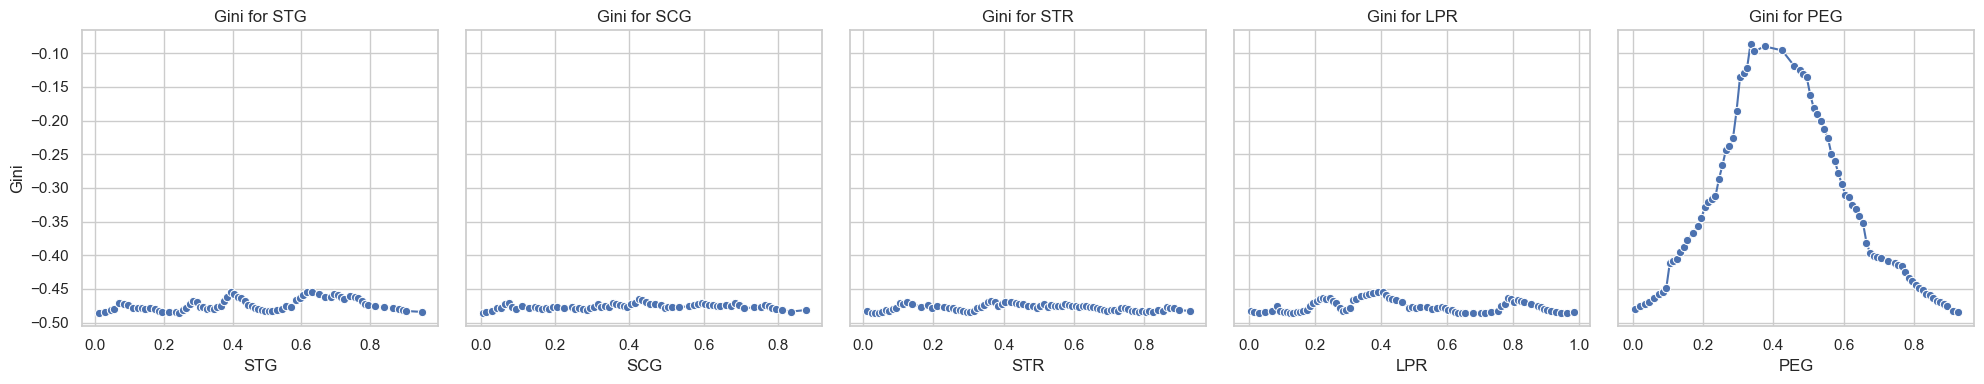

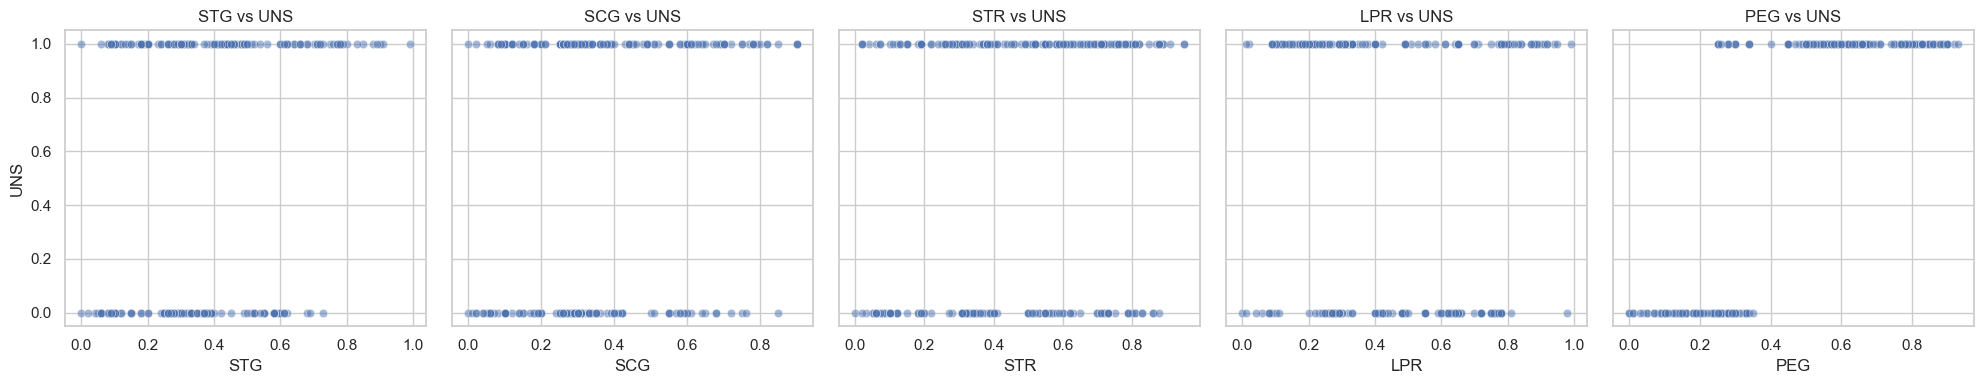

In [7]:
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
target = 'UNS'


fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(len(features) * 4, 4), sharey=True)

for i, feature in enumerate(features):
    thresholds, ginis = find_best_split(df[feature], df[target])[:2]
    sns.lineplot(x=thresholds, y=ginis, ax=axes[i], marker="o")
    axes[i].set_title(f"Gini for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Gini" if i == 0 else "")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(len(features) * 4, 4), sharey=True)

for i, feature in enumerate(features):
    sns.scatterplot(x=df[feature], y=df[target], alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{feature} vs {target}")
    axes[i].set_xlabel(feature)
    if i == 0:
        axes[i].set_ylabel(target)
    else:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**

- Деление производится по признаку "PEG"
- Да, результат согасуется, там тоже наблюдается наилучшая разделимость
- Хороший признак создаёт график, где классы разделяются чётко
- Плохой признак создаёт шумовой, хаотичный график, где классы неотличимы друг от друга

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [8]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [9]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)


X = mushroom.data.features
y = mushroom.data.targets

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_le = [le.fit_transform(X[i]) for i in X.columns]


In [11]:
X_le = pd.DataFrame(X_le).T
X_le.columns = [X.columns]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_le, y, test_size=0.5, random_state=42)

In [178]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter

def find_best_split(feature_vector, target_vector):
    unique_values = np.unique(feature_vector)
    if len(unique_values) == 1:
        return np.array([]), np.array([]), None, None

    thresholds = (unique_values[:-1] + unique_values[1:]) / 2
    ginis = np.zeros_like(thresholds)

    total_samples = len(target_vector)
    total_p1 = np.sum(target_vector == 1)
    total_p0 = total_samples - total_p1

    sorted_indices = np.argsort(feature_vector)
    sorted_features = feature_vector[sorted_indices]
    sorted_targets = target_vector[sorted_indices]

    left_p1, left_p0 = 0, 0
    right_p1, right_p0 = total_p1, total_p0

    for i, threshold in enumerate(thresholds):
        mask = sorted_features <= threshold
        left_size = np.sum(mask)
        right_size = total_samples - left_size

        left_p1 = np.sum(sorted_targets[:left_size] == 1)
        left_p0 = left_size - left_p1
        right_p1 = total_p1 - left_p1
        right_p0 = total_p0 - left_p0

        h_left = 1 - (left_p1 / left_size) ** 2 - (left_p0 / left_size) ** 2 if left_size > 0 else 0
        h_right = 1 - (right_p1 / right_size) ** 2 - (right_p0 / right_size) ** 2 if right_size > 0 else 0

        ginis[i] = - (left_size / total_samples) * h_left - (right_size / total_samples) * h_right

    best_idx = np.argmax(ginis)
    return thresholds, ginis, thresholds[best_idx], ginis[best_idx]

class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        if not all(x in {"real", "categorical"} for x in feature_types):
            raise ValueError("There is an unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node, depth=0):
        if np.all(sub_y == sub_y[0]) or (self._max_depth is not None and depth >= self._max_depth):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                unique_values = np.unique(sub_X[:, feature])
                categories_map = {val: i for i, val in enumerate(unique_values)}
                feature_vector = np.array([categories_map[val] for val in sub_X[:, feature]])
            else:
                raise ValueError("Unknown feature type")

            if len(feature_vector) < self._min_samples_split:
                continue

            result = find_best_split(feature_vector, sub_y)
            if result is not None:
                _, _, threshold, gini = result
                if gini is not None and (gini_best is None or gini > gini_best):
                    feature_best, gini_best, threshold_best = feature, gini, threshold
                    if threshold is not None:
                        split = feature_vector < threshold
                    else:
                        split = np.zeros_like(feature_vector, dtype=bool)

        if feature_best is None or gini_best is None or len(sub_y) < self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best if self._feature_types[feature_best] == "real" else None
        node["categories_split"] = categories_map if self._feature_types[feature_best] == "categorical" else None

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"], depth + 1)

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]

        feature_index = int(node["feature_split"])
        feature_value = x[feature_index]

        if self._feature_types[feature_index] == "real":
            return self._predict_node(x, node["left_child"] if feature_value < node["threshold"] else node["right_child"])
        elif self._feature_types[feature_index] == "categorical":
            category_map = node["categories_split"]
            category_index = category_map.get(feature_value, -1)
            return self._predict_node(x, node["left_child"] if category_index == 0 else node["right_child"])
        else:
            raise ValueError(f"Unknown feature type: {self._feature_types[feature_index]} for feature {feature_index}")

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        if len(self._feature_types) != X.shape[1]:
            raise ValueError("Feature types length does not match number of features in X")
        self._fit_node(X, y, self._tree)
        return self

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_node(x, self._tree) for x in X])

    def get_params(self, deep=True):
        return {
            "feature_types": self._feature_types,
            "max_depth": self._max_depth,
            "min_samples_split": self._min_samples_split,
            "min_samples_leaf": self._min_samples_leaf,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [59]:
from sklearn.metrics import accuracy_score

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()

feature_types = ["real"] * X_train.shape[1]

dt = DecisionTree(feature_types=feature_types)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9961


### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [176]:
tic_tac_toe_endgame = fetch_ucirepo(id=101)

X_tic = tic_tac_toe_endgame.data.features
y_tic = tic_tac_toe_endgame.data.targets

X_train, X_test, y_train, y_test = train_test_split(X_tic, y_tic, test_size=0.5, random_state=42)

encoder = LabelEncoder()

for column in X_tic.columns:
    X_train[column] = encoder.fit_transform(X_train[column])
    X_test[column] = encoder.transform(X_test[column])

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Text(0, 0.5, 'accuracy')

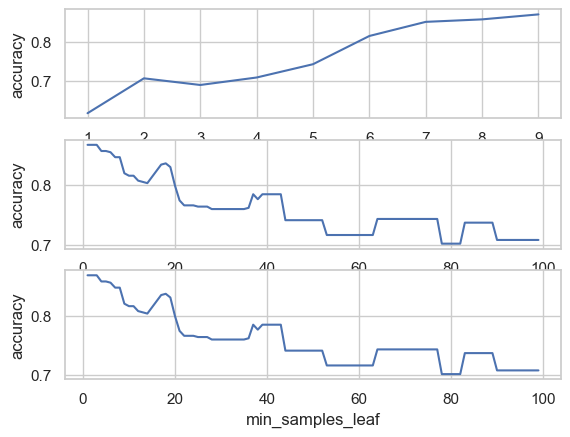

In [180]:
feature_types = ['real'] * X_train.shape[1]

fig, ax = plt.subplots(3, 1)

depths = np.arange(1, 10)
min_samples_split = np.arange(1, 100)
min_samples_leaf = np.arange(1, 100)

accuracies = []

for depth in depths:
    tree = DecisionTree(feature_types=feature_types, max_depth=depth)

    tree.fit(X=X_train, y=y_train)
    y_pred = tree.predict(X=X_test)

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracies.append(accuracy)

lineplot_depths = sns.lineplot(x=depths, y=accuracies, ax=ax[0])
lineplot_depths.set_xlabel('depths')
lineplot_depths.set_ylabel('accuracy')

accuracies.clear()

for min_sample_split in min_samples_split:
    tree = DecisionTree(feature_types=feature_types, min_samples_split=min_sample_split)

    tree.fit(X=X_train, y=y_train)
    y_pred = tree.predict(X=X_test)

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    accuracies.append(accuracy)

lineplot_split = sns.lineplot(x=min_samples_split, y=accuracies, ax=ax[1])
lineplot_split.set_xlabel('min_samples_split')
lineplot_split.set_ylabel('accuracy')

accuracies.clear()

for min_sample_leaf in min_samples_leaf:
    tree = DecisionTree(feature_types=feature_types, min_samples_leaf=min_sample_leaf)

    tree.fit(X=X_train, y=y_train)
    y_pred = tree.predict(X=X_test)

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)    
    accuracies.append(accuracy)

lineplot_leaf = sns.lineplot(x=min_samples_leaf, y=accuracies, ax=ax[2])
lineplot_leaf.set_xlabel('min_samples_leaf')
lineplot_leaf.set_ylabel('accuracy')

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [110]:
mushroom = fetch_ucirepo(id=73)

X_mush = mushroom.data.features
y_mush = mushroom.data.targets

tic_tac_toe_endgame = fetch_ucirepo(id=101)

X_tic = tic_tac_toe_endgame.data.features
y_tic = tic_tac_toe_endgame.data.targets

nursery = fetch_ucirepo(id=76)

X_nur = nursery.data.features
y_nur = nursery.data.targets

car_evaluation = fetch_ucirepo(id=19)

X_car = car_evaluation.data.features
y_car = car_evaluation.data.targets

In [96]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter

class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        if not all(x in {"real", "categorical"} for x in feature_types):
            raise ValueError("There is an unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node, depth=0):
        if np.all(sub_y == sub_y[0]) or (self._max_depth is not None and depth >= self._max_depth):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        if len(sub_y) < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y.astype(bool), feature].ravel() if isinstance(sub_X, np.ndarray) else sub_X.iloc[sub_y.astype(bool).values, feature]) 
                ratio = {key: counts[key] / (clicks[key] + 1) for key in counts}
                sorted_categories = sorted(ratio, key=ratio.get)
                categories_map = {cat: i for i, cat in enumerate(sorted_categories)}
                feature_vector = np.array([categories_map[x] for x in sub_X[:, feature]])
            else:
                raise ValueError("Unknown feature type")

            if len(feature_vector) < self._min_samples_split:
                continue

            result = find_best_split(feature_vector, sub_y)
            if result is not None:
                _, _, threshold, gini = result
                if gini is not None and (gini_best is None or gini > gini_best):
                    feature_best, gini_best, threshold_best = feature, gini, threshold
                    if threshold is not None:
                        split = feature_vector < threshold 
                    else:
                        split = np.zeros_like(feature_vector, dtype=bool)

        if feature_best is None or gini_best is None or len(sub_y) < self._min_samples_leaf:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best if self._feature_types[feature_best] == "real" else None
        node["categories_split"] = sorted_categories if self._feature_types[feature_best] == "categorical" else None

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"], depth + 1)

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]

        feature_index = int(node["feature_split"])
        feature_value = x[feature_index]

        if self._feature_types[feature_index] == "real":
            return self._predict_node(x, node["left_child"] if feature_value < node["threshold"] else node["right_child"])
        elif self._feature_types[feature_index] == "categorical":
            if node["categories_split"] is not None and feature_value in node["categories_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError(f"Unknown feature type: {self._feature_types[feature_index]} for feature {feature_index}")

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        if len(self._feature_types) != X.shape[1]:
            raise ValueError("Feature types length does not match number of features in X")
        self._fit_node(X, y, self._tree)
        return self

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_node(x, self._tree) for x in X])

    def get_params(self, deep=True):
        return {
            "feature_types": self._feature_types,
            "max_depth": self._max_depth,
            "min_samples_split": self._min_samples_split,
            "min_samples_leaf": self._min_samples_leaf,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

le = LabelEncoder()

X_le_mush = [le.fit_transform(X_mush[i]) for i in X_mush.columns]
X_le_mush = pd.DataFrame(X_le_mush).T
X_le_mush.columns = [X_le_mush.columns]

marks = []

feature_types = ["real"] * X_le_mush.shape[1]

dt = DecisionTree(feature_types=feature_types)

print(f'accuracy mashrooms with real features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_mush, y_mush, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_mush, y_mush, cv=10, scoring="accuracy").mean())

feature_types = ["categorical"] * X_le_mush.shape[1]

print(f'accuracy mashrooms with cat features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_mush, y_mush, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_mush, y_mush, cv=10, scoring="accuracy").mean())

X_mush_ohe = pd.get_dummies(X_mush, sparse=False)

feature_types = ["real"] * X_mush_ohe.shape[1]

dt = DecisionTree(feature_types=feature_types)

print(f'accuracy mashrooms with real features and OHE and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_mush_ohe, y_mush, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_mush_ohe, y_mush, cv=10, scoring="accuracy").mean())

feature_types = ["real"] * X_le_mush.shape[1]

print(f'DecisionTreeClassifier accuracy mashrooms with real features and CV=10 = {cross_val_score(DecisionTreeClassifier(random_state=42), X_le_mush, y_mush, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTreeClassifier(random_state=42), X_le_mush, y_mush, cv=10, scoring="accuracy").mean())

models = ['real', 'categorical', 'OHE', 'sklearn']
data = ['mushroom' for x in range(4)]

accuracy mashrooms with real features and CV=10 = 0.9565561776307417
accuracy mashrooms with cat features and CV=10 = 0.7454792503590062
accuracy mashrooms with real features and OHE and CV=10 = 0.9554478032465052
DecisionTreeClassifier accuracy mashrooms with real features and CV=10 = 0.956689025018329


In [112]:
mush_score = pd.DataFrame(data, columns=['data'])\
    .merge(pd.DataFrame(marks, columns=['score']), left_index=True, right_index=True)\
    .merge(pd.DataFrame(models, columns=['models']), left_index=True, right_index=True)

In [113]:
X_le_tic = [le.fit_transform(X_tic[i]) for i in X_tic.columns]
X_le_tic = pd.DataFrame(X_le_tic).T
X_le_tic.columns = [X_tic.columns]
feature_types = ["real"] * X_tic.shape[1]
y_tic = [1 if str(x) in {'positive'} else 0 for x in y_tic.values.ravel()]


marks = []

dt = DecisionTree(feature_types=feature_types)
print(f'accuracy tic with real features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_tic, y_tic, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_tic, y_tic, cv=10, scoring="accuracy").mean())

feature_types = ["categorical"] * X_tic.shape[1]

print(f'accuracy tic with cat features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_tic, y_tic, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_tic, y_tic, cv=10, scoring="accuracy").mean())

X_tic_ohe = pd.get_dummies(X_tic, sparse=False)

feature_types = ["real"] * X_tic_ohe.shape[1]

dt = DecisionTree(feature_types=feature_types)

print(f'accuracy tic with real features and OHE and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_tic_ohe, y_tic, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_tic_ohe, y_tic, cv=10, scoring="accuracy").mean())

feature_types = ["real"] * X_le_tic.shape[1]

print(f'DecisionTreeClassifier accuracy tic with real features and CV=10 = {cross_val_score(DecisionTreeClassifier(random_state=42), X_le_tic, y_tic, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTreeClassifier(random_state=42), X_le_tic, y_tic, cv=10, scoring="accuracy").mean())

models = ['real', 'categorical', 'OHE', 'sklearn']
data = ['tic_tac_toe' for x in range(4)]

accuracy tic with real features and CV=10 = 0.7706030701754385
accuracy tic with cat features and CV=10 = 0.631469298245614
accuracy tic with real features and OHE and CV=10 = 0.8174890350877192
DecisionTreeClassifier accuracy tic with real features and CV=10 = 0.7716776315789474


In [114]:
tic_tac_score = pd.DataFrame(data, columns=['data'])\
    .merge(pd.DataFrame(marks, columns=['score']), left_index=True, right_index=True)\
    .merge(pd.DataFrame(models, columns=['models']), left_index=True, right_index=True)

In [115]:
X_le_nur = [le.fit_transform(X_nur[i]) for i in X_nur.columns]
X_le_nur = pd.DataFrame(X_le_nur).T
X_le_nur.columns = [X_nur.columns]
feature_types = ["real"] * X_nur.shape[1]
y_nur = [1 if str(x) in {'very_recom', 'priority', 'spec_prior'} else 0 for x in y_nur.values.ravel()]

marks = []

dt = DecisionTree(feature_types=feature_types)
print(f'accuracy nur with real features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_nur, y_nur, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_nur, y_nur, cv=10, scoring="accuracy").mean())

feature_types = ["categorical"] * X_nur.shape[1]

print(f'accuracy nur with cat features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_nur, y_nur, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_nur, y_nur, cv=10, scoring="accuracy").mean())

X_nur_ohe = pd.get_dummies(X_nur, sparse=False)

feature_types = ["real"] * X_nur_ohe.shape[1]

dt = DecisionTree(feature_types=feature_types)

print(f'accuracy nur with real features and OHE and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_nur_ohe, y_nur, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_nur_ohe, y_nur, cv=10, scoring="accuracy").mean())

feature_types = ["real"] * X_le_nur.shape[1]

print(f'DecisionTreeClassifier accuracy tic with real features and CV=10 = {cross_val_score(DecisionTreeClassifier(random_state=42), X_le_nur, y_nur, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTreeClassifier(random_state=42), X_le_nur, y_nur, cv=10, scoring="accuracy").mean())

models = ['real', 'categorical', 'OHE', 'sklearn']
data = ['nursery' for x in range(4)]

accuracy nur with real features and CV=10 = 0.9996913580246914
accuracy nur with cat features and CV=10 = 0.9993827160493828
accuracy nur with real features and OHE and CV=10 = 0.999537037037037
DecisionTreeClassifier accuracy tic with real features and CV=10 = 0.9996913580246914


In [116]:
nursery_score = pd.DataFrame(data, columns=['data'])\
    .merge(pd.DataFrame(marks, columns=['score']), left_index=True, right_index=True)\
    .merge(pd.DataFrame(models, columns=['models']), left_index=True, right_index=True)

In [117]:
X_le_car = [le.fit_transform(X_car[i]) for i in X_car.columns]
X_le_car = pd.DataFrame(X_le_car).T
X_le_car.columns = [X_car.columns]
feature_types = ["real"] * X_car.shape[1]
y_car = [1 if str(x) in {'good', 'vgood'} else 0 for x in y_car.values.ravel()]

marks = []

dt = DecisionTree(feature_types=feature_types)
print(f'accuracy car with real features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_car, y_car, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_car, y_car, cv=10, scoring="accuracy").mean())

feature_types = ["categorical"] * X_car.shape[1]
print(f'accuracy car with cat features and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_le_car, y_car, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_le_car, y_car, cv=10, scoring="accuracy").mean())

X_car_ohe = pd.get_dummies(X_car, sparse=False)

feature_types = ["real"] * X_car_ohe.shape[1]

dt = DecisionTree(feature_types=feature_types)

print(f'accuracy car with real features and OHE and CV=10 = {cross_val_score(DecisionTree(feature_types=feature_types), X_car_ohe, y_car, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTree(feature_types=feature_types), X_car_ohe, y_car, cv=10, scoring="accuracy").mean())

feature_types = ["real"] * X_le_car.shape[1]

print(f'DecisionTreeClassifier accuracy car with real features and CV=10 = {cross_val_score(DecisionTreeClassifier(random_state=42), X_le_car, y_car, cv=10, scoring="accuracy").mean()}')

marks.append(cross_val_score(DecisionTreeClassifier(random_state=42), X_le_car, y_car, cv=10, scoring="accuracy").mean())

models = ['real', 'categorical', 'OHE', 'sklearn']
data = ['car' for x in range(4)]

accuracy car with real features and CV=10 = 0.9473316305955102
accuracy car with cat features and CV=10 = 0.9224559752654926
accuracy car with real features and OHE and CV=10 = 0.8289487834386342
DecisionTreeClassifier accuracy car with real features and CV=10 = 0.9427073531388628


In [118]:
car_score = pd.DataFrame(data, columns=['data'])\
    .merge(pd.DataFrame(marks, columns=['score']), left_index=True, right_index=True)\
    .merge(pd.DataFrame(models, columns=['models']), left_index=True, right_index=True)

In [123]:
pd.concat([mush_score, tic_tac_score, nursery_score, car_score]).pivot(index="data", columns="models", values="score")

models,OHE,categorical,real,sklearn
data,,,,
car,0.828949,0.922456,0.947332,0.942707
mushroom,0.955448,0.745479,0.956556,0.956689
nursery,0.999537,0.999383,0.999691,0.999691
tic_tac_toe,0.817489,0.631469,0.770603,0.771678


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

```
Ответ:
- Нет, качество алгоритма меняется в зависимости от набора данных. Считаю, что такое происходит из-за более эффективной реализации работы с данными определенной специфики в самописном алгоритме.
- Случайности присутствует, иначе бы получали одинаковые значения метрик.
- На случайность можно повлиять фиксируя random state.
```

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [136]:
!mkdir -p ~/.postgresql && \
curl -o ~/.postgresql/root.crt "https://storage.yandexcloud.net/cloud-certs/CA.pem" && \
chmod 0600 ~/.postgresql/root.crt

python(23505) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3579  100  3579    0     0   8128      0 --:--:-- --:--:-- --:--:--  8134


### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

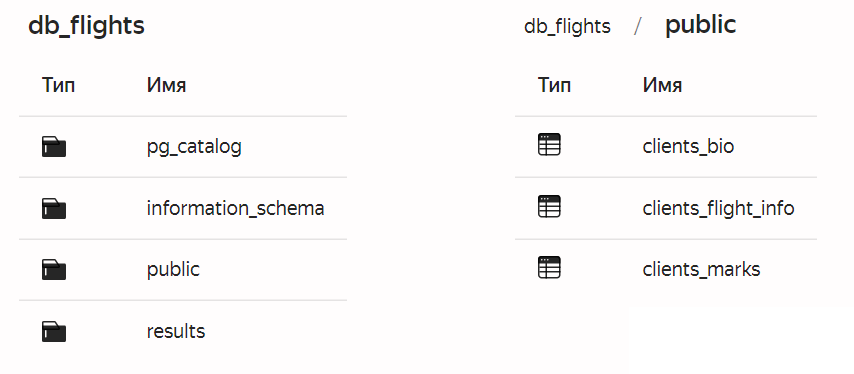

In [137]:
with psycopg2.connect(
        '''
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
        ''') as conn:
    with conn.cursor() as cur:
        cur.execute(
            '''
SELECT
b.gender,
b.age,
i."Customer Type",
i."Type of Travel",
i.class,
i."Flight Distance",
i."Departure Delay in Minutes",
i."Arrival Delay in Minutes",
m."Inflight wifi service",
m."Departure/Arrival time convenient",
m."Ease of Online booking",
m."Gate location",
m."Food and drink",
m."Online boarding",
m."Seat comfort",
m."Inflight entertainment",
m."On-board service",
m."Leg room service",
m."Baggage handling",
m."Checkin service",
m."Inflight service",
m.cleanliness,
m.satisfaction
FROM clients_bio b
INNER JOIN clients_flight_info i ON b.id = i.id
INNER JOIN clients_marks m ON b.id = m.id;
            ''')

        data = cur.fetchall()
        columns = [
            'gender',
            'age',
            'Customer Type',
            'Type of Travel',
            'class',
            'Flight Distance',
            'Departure Delay in Minutes',
            'Arrival Delay in Minutes',
            'Inflight wifi service',
            'Departure/Arrival time convenient',
            'Ease of Online booking',
            'Gate location',
            'Food and drink',
            'Online boarding',
            'Seat comfort',
            'Inflight entertainment',
            'On-board service',
            'Leg room service',
            'Baggage handling',
            'Checkin service',
            'Inflight service',
            'cleanliness',
            'satisfaction'
        ]

        conn.commit()

df = pd.DataFrame(data=data, columns=columns)

In [138]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [139]:
df_train = df[df.satisfaction != '-']

df_train.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
0,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
1,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
2,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
3,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
4,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [140]:
assert df_train.shape == (103_644, 23)

In [141]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
5,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
7,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
12,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
19,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
24,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0


In [142]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [143]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [144]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [145]:
categorical_features = ['gender', 'Customer Type', 'Type of Travel', 'class']
numerical_features = list(set(X_train.columns) - set(categorical_features))

X_train[numerical_features] = X_train[numerical_features].astype(float)
X_val[numerical_features] = X_val[numerical_features].astype(float)



In [146]:
display(X_train['Customer Type'].value_counts(normalize=True))
display(X_train['gender'].value_counts(normalize=True))
display(X_train['class'].value_counts(normalize=False))
display(X_train['Type of Travel'].value_counts(normalize=True))

Customer Type
Loyal Customer       0.818112
disloyal Customer    0.181172
nan                  0.000717
Name: proportion, dtype: float64

gender
Female    0.507457
Male      0.492543
Name: proportion, dtype: float64

class
Business    34727
Eco         32546
Eco Plus     5211
nan            66
Name: count, dtype: int64

Type of Travel
Business travel    0.688959
Personal Travel    0.310076
nan                0.000965
Name: proportion, dtype: float64

In [147]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

X_train = pd.DataFrame(
    data=imputer.fit_transform(X=X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val = pd.DataFrame(
    data=imputer.transform(X=X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_train[numerical_features] = X_train[numerical_features].astype(float)
X_val[numerical_features] = X_val[numerical_features].astype(float)

```
Категориальные признаки:
- Gender: клиенты разбиты почти равномерно;
- Customer Type: есть перекос в сторону лояльных клиенты ;
- Type of Travel: большинство поездок бизнесс класса;
- Class: самый частый вид облуживания - бизнес класс.

Числовые признаки:
- Age: клиенты возрастные - В данных наблюдаются аномали: максимальный возраст - 544 года, минимальный - 0 лет (как будто заглушка). средний возраст 40 лет.
- Flight Distance: максимальной длина перелёта 379 620.
- Остальные признаки: аномалий на горизонте не наблюдается.

Выбросы:
- Категориальные признаки: аномально низкое значение Eco Plus класса обслуживания.
- Числовые признаки: по кол-ву выбросов больше всего в признаках: задержка в отбытии/прибытии самолёта, услуги регистрации, дистанция полёта.
```

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

In [148]:
y_train.value_counts(normalize=True)

satisfaction
neutral or dissatisfied    0.566272
satisfied                  0.433728
Name: proportion, dtype: float64

`в таргете нет сильного дисбаланса, поэтому приведем его к бинарному виду, основная предобработка сделана на предыдущих шагах`

In [151]:
y_train = [1 if x == 'satisfied' else 0 for x in y_train.values]
y_val = [1 if x == 'satisfied' else 0 for x in y_val.values]

```
Закодируем через OHE пол, типа поездки, типа клиента. В классе есть упорядоченность, поэтому используем Ordinal.
```

In [153]:
X_train = pd.get_dummies(data=X_train, columns=['gender', 'Customer Type', 'Type of Travel'], dtype=int)
X_train['class'] = X_train.apply( lambda row: 1 if row['class'] == 'Eco' else (2 if row['class'] == 'Eco Plus' else 3), axis=1)
X_val = pd.get_dummies(data=X_val, columns=['gender', 'Customer Type', 'Type of Travel'], dtype=int)
X_val['class'] = X_val.apply(lambda row: 1 if row['class'] == 'Eco' else (2 if row['class'] == 'Eco Plus' else 3), axis=1)

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [155]:
from sklearn.metrics import f1_score

tree = DecisionTree(feature_types=['real'] * X_train.shape[1])

tree.fit(X=X_train, y=y_train)
y_pred = tree.predict(X=X_val)

f1_score(y_true=y_val, y_pred=y_pred)

0.9339969542770122

In [156]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

rfc.fit(X=X_train, y=y_train)
y_pred = rfc.predict(X=X_val)

f1_score(y_true=y_val, y_pred=y_pred)

0.9558600847970927

### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [159]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth': np.arange(start=2, stop=10), 
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2, 10)}

rscv_rfc = RandomizedSearchCV(
    estimator=rfc, param_distributions=param_distributions, n_iter=10, scoring=make_scorer(f1_score), n_jobs=-1, random_state=42
)

rscv_rfc.fit(X=X_train, y=y_train)
y_pred = rscv_rfc.predict(X=X_val)

f1_score(y_true=y_val, y_pred=y_pred)

0.9327579737335836

In [161]:
rscv_tree = RandomizedSearchCV(estimator=tree, param_distributions=param_distributions, n_iter=10, scoring=make_scorer(f1_score), n_jobs=-1, random_state=42)

rscv_tree.fit(X=X_train, y=y_train)
y_pred = rscv_tree.predict(X=X_val)

f1_score(y_true=y_val, y_pred=y_pred)        

0.9339969542770122

`Полученные модели очень близки по качеству, сохраним вторую модель`

In [162]:
with open('model.pkl', 'wb') as f:
    pickle.dump(rscv_tree, f)





### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [166]:
fi = pd.DataFrame(data=rscv_rfc.best_estimator_.feature_importances_, index=X_train.columns)
fi.rename(columns={0: 'feature_importance'}, inplace=True)
fi.sort_values(by='feature_importance', ascending=False, inplace=True)

In [164]:
fi

,feature_importance
Online boarding,0.181824
Inflight wifi service,0.135976
class,0.115835
Type of Travel_Business travel,0.090837
Inflight entertainment,0.076229
Type of Travel_Personal Travel,0.075877
Seat comfort,0.049156
Ease of Online booking,0.039701
Customer Type_disloyal Customer,0.034221
Customer Type_Loyal Customer,0.033153


`
Самыми важными оказались: онлайн-регистрация, Wi-Fi, класс обслуживания, тип поездки - бизнес, развлечения.
`

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

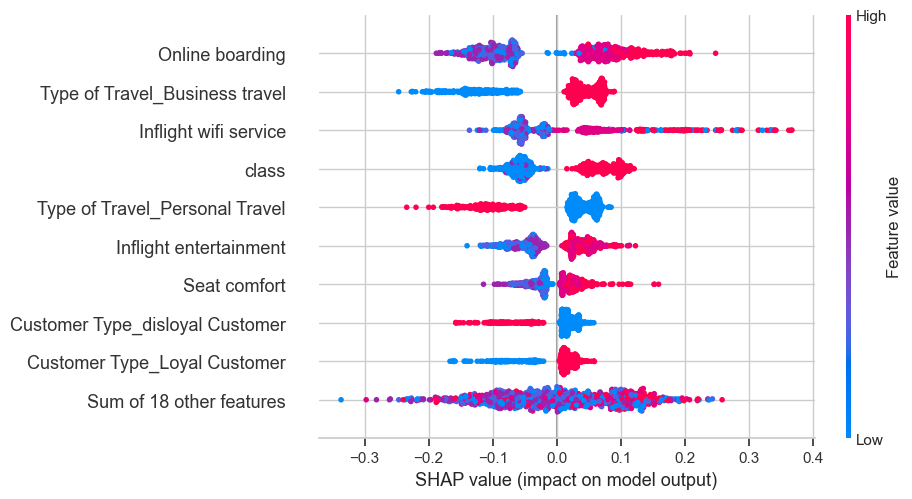

In [170]:
expl = shap.TreeExplainer(model=rscv_rfc.best_estimator_)
explntion = expl(X_val.sample(1_000))
shap.plots.beeswarm(explntion[:,:,1])

`Порядок важности немного отличается от предыдушего вывода, через features_importance. Основным фактором тут является значение онлайн регистрации, так как больше всего оказывает влияние на удовлетворенность клиентом`

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

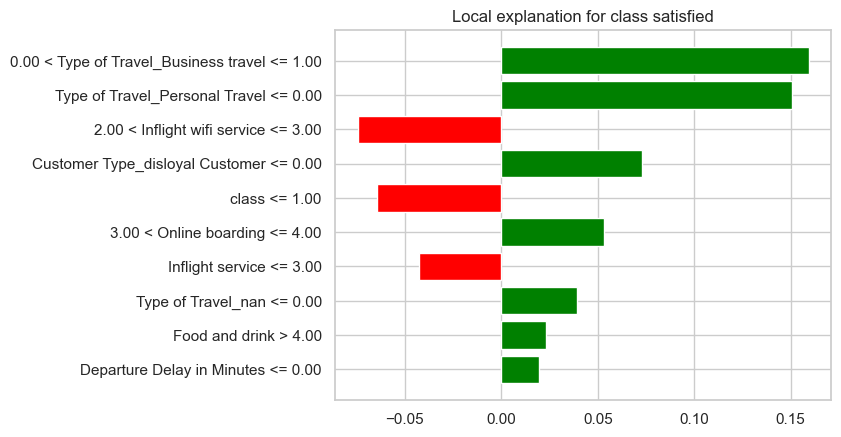

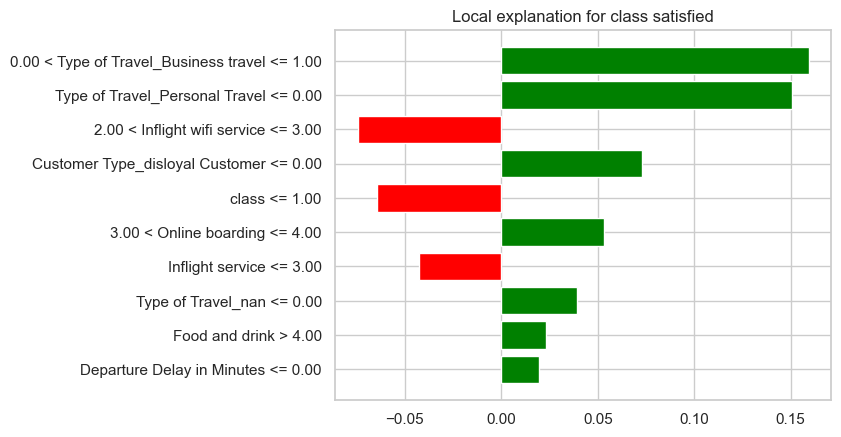

In [175]:
import lime.lime_tabular as lime_tabular

explr = lime_tabular.LimeTabularExplainer(training_data=X_train.to_numpy(), feature_names=X_train.columns, class_names=['not satisfied / neutral', 'satisfied'], mode='classification')
index = np.random.randint(0, X_val.shape[0])
explntion = explr.explain_instance(data_row=X_val.iloc[index, :], predict_fn=rscv_rfc.best_estimator_.predict_proba, num_features=10)
explntion.as_pyplot_figure()

`Видно, что для конкретного клиента удоблетворенность в большинстве своем зависит от типа перелета, онлайн бронирования, а его неудоблетворенность складывается из качества WI-FI сервиса, класса и сервиса обсуживания во время рейса`

## Котобонус!

0.25 балла

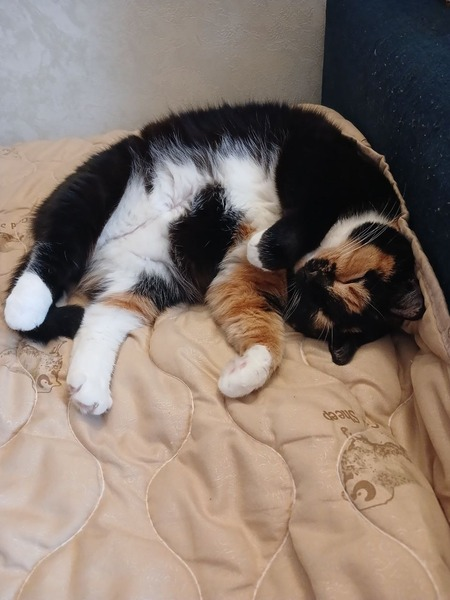

`Это кот Елены Кантонистовой`

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

`самая сложная домашка, на деревьях умер, спасибо !`